In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from Vis import plot_loss, plot_roc
from Preprocessing import Preprocessing
from Preprocessing import Cols
import numpy as np
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from pandas import DataFrame
from pandas import Series
import pandas as pd
from keras.layers import Dropout
from sklearn.preprocessing import OneHotEncoder
import numpy as np
# pandas.set_option('max_columns',10)

Using TensorFlow backend.


In [2]:
pre = Preprocessing()
X, y = pre.load_data(time_gap=300)

prepared dataset contains: per_stud_dataset + per_action_dataset_summ


In [3]:
per_action_dataset = pre.per_action_dataset
per_action_dataset.index = per_action_dataset.ITEST_id
per_action_dataset = per_action_dataset.drop("ITEST_id", axis=1)
per_action_dataset = per_action_dataset.drop(['assistmentId', 'problemId', 'assignmentId', 'actionId'], axis=1)

In [4]:
# show the seq of a sample student (id =9)
#per_action_dataset[per_action_dataset.index.get_level_values(0) ==9].head()

In [5]:
#truncating seq of each student and only considering his last 500 actions based on startTime feature
truncated_input = per_action_dataset.sort_values("startTime",ascending=False).groupby('ITEST_id').head(500)

In [6]:
# scaling dataset
scaler = RobustScaler()
X_scaled = scaler.fit_transform(truncated_input)
X_scaled = DataFrame(X_scaled, index=truncated_input.index, columns=truncated_input.columns)
#X_scaled[X_scaled.index.get_level_values(0) ==9].head()

In [7]:
# defining sequence length (or number of time-steps) for each student and batch-size
max_length_seq = 1000

In [8]:
batch_size=10

In [9]:
# padding sequences to have a same length
X_padded = []
for stud_id, stud_seq in X_scaled.groupby(by='ITEST_id'):
    X_padded.append(stud_seq)
X_padded = sequence.pad_sequences(X_padded, max_length_seq, dtype='float64')

In [10]:
pd.set_option('max_columns',90)
# getting a sense about padded dataset
new_seq_ix = pd.Index(list(range(0,max_length_seq))* X_padded.shape[0], name="seq_ix")
ITEST_ix = pd.Index(np.repeat(sorted(X_scaled.index.get_level_values(0).unique()), max_length_seq), name='ITEST_id')
paddedData = DataFrame(X_padded.reshape(X_padded.shape[0]*X_padded.shape[1], -1), index=[ITEST_ix, new_seq_ix], columns=X_scaled.columns)
#paddedData[paddedData.index.get_level_values(0) == 27].head()

In [11]:
# creating label dataset with index as ITEST_id values
label_dataset = pre.label_dataset[['ITEST_id', 'isSTEM']]
label_dataset.index = label_dataset.ITEST_id
label_dataset = label_dataset.drop("ITEST_id", axis = 1)
#label_dataset

In [12]:
# join label with dataset to make sure we have a consistent dataset
# (of course before the training the label column will be droped from data)
X_with_label = paddedData.join(label_dataset)
#print(X_with_label.shape)
#X_with_label

In [16]:
from sklearn.utils import resample

df_majority = X_with_label[X_with_label['isSTEM'] == 0]
df_minority = X_with_label[X_with_label['isSTEM'] == 1]

minority_len = len(df_minority.index.get_level_values(0).unique())
majority_len = len(df_majority.index.get_level_values(0).unique())

sampled_df_majority = df_majority.loc[resample(df_majority.index.get_level_values(0).unique(), n_samples=minority_len, replace=False).values]

balanced_X = pd.concat([df_minority, sampled_df_majority])

In [17]:
y_prepared = balanced_X.groupby("ITEST_id").isSTEM.first().values
X_prepared = balanced_X.drop("isSTEM", axis=1)
X_prepared = X_prepared.values.reshape((-1, max_length_seq, X_prepared.shape[1]))
#print(X_prepared.shape)
#X_prepared

## Model

In [18]:
def create_LSTM_model(max_length_seq, feature_size):
    # create the LSTM network
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(max_length_seq, feature_size)))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
# splitting train/test data 
X_train, X_test, y_train,y_test = train_test_split(X_prepared,y_prepared, train_size=.65)
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()

In [20]:
# Create model
model = create_LSTM_model(max_length_seq, X_train.shape[2])
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size)

Epoch 1/5
152/152 [==============================] - 67s - loss: 0.7067 - acc: 0.5000    
Epoch 2/5
152/152 [==============================] - 63s - loss: 0.6682 - acc: 0.6316    
Epoch 3/5
152/152 [==============================] - 66s - loss: 0.6485 - acc: 0.6250    
Epoch 4/5
152/152 [==============================] - 67s - loss: 0.6007 - acc: 0.7237    
Epoch 5/5
152/152 [==============================] - 68s - loss: 0.5606 - acc: 0.7039    


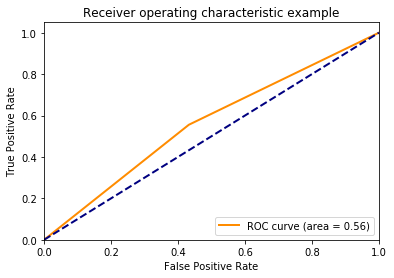

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1000, 100)         59200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000, 100)         80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 220,202
Trainable params: 220,202
Non-trainable params: 0
_________________________________________________________________
None
Test ROC Score: 0.557357
Test RMSE Score: 0.515889
Final Competition Score: 1.041468


In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from Vis import plot_accuracy
# do prediction
y_pred = model.predict(X_test, batch_size=batch_size)

# calculating scores
roc_score = roc_auc_score(y_test, y_pred)
mse_score = mean_squared_error(y_test, y_pred)

#printing and plotting model and score information
#plot_loss(history)
plot_roc(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
# plot_accuracy(history)

print(model.summary())
print("Test ROC Score: %f" % roc_score)
print("Test RMSE Score: %f" % sqrt(mse_score))
print("Final Competition Score: %f" % (1 - sqrt(mse_score) + roc_score))

## EDA

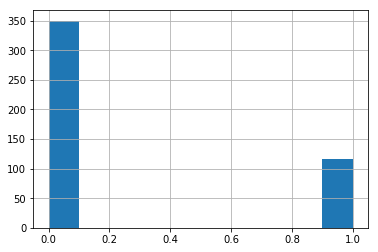

In [25]:
# see the dist. of labels: unbalanced labels!
X_with_label.groupby('ITEST_id').isSTEM.mean().hist()

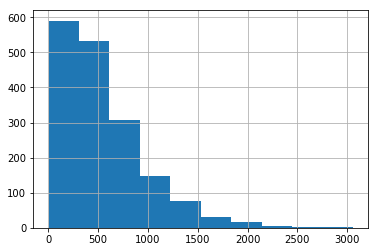

In [3]:
# number of actions for each student before summarization
pre.raw_dataset.groupby("ITEST_id").size().hist()

In [55]:
print("Number of stud with Non-STEM label: ", len(df_majority.index.get_level_values(0).unique()))
print("Number of stud with STEM label:", len(df_minority.index.get_level_values(0).get_level_values(0).unique()))
print("Number of actions for stud with Non-STEM label: ", df_majority.isSTEM.count())
print("Number of actions for stud with Non-STEM label: ", df_minority.isSTEM.count())

Number of stud with Non-STEM label:  350
Number of stud with STEM label: 117
Number of actions for stud with Non-STEM label:  350000
Number of actions for stud with Non-STEM label:  117000
